This notebook was prepared by [Donne Martin](http://donnemartin.com). Source and license info is on [GitHub](https://github.com/donnemartin/data-science-ipython-notebooks).

# matplotlib-applied

* Applying Matplotlib Visualizations to Kaggle: Titanic
* Bar Plots, Histograms, subplot2grid
* Normalized Plots
* Scatter Plots, subplots
* Kernel Density Estimation Plots

## Applying Matplotlib Visualizations to Kaggle: Titanic

Prepare the titanic data to plot:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
import seaborn

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()

In [2]:
df_train = pd.read_csv('../data/titanic/train.csv')

def clean_data(df):
    
    # Get the unique values of Sex
    sexes = np.sort(df['Sex'].unique())
    
    # Generate a mapping of Sex from a string to a number representation    
    genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))

    # Transform Sex from a string to a number representation
    df['Sex_Val'] = df['Sex'].map(genders_mapping).astype(int)
    
    # Get the unique values of Embarked
    embarked_locs = np.sort(df['Embarked'].unique())

    # Generate a mapping of Embarked from a string to a number representation        
    embarked_locs_mapping = dict(zip(embarked_locs, 
                                     range(0, len(embarked_locs) + 1)))
    
    # Transform Embarked from a string to dummy variables
    df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked_Val')], axis=1)
    
    # Fill in missing values of Embarked
    # Since the vast majority of passengers embarked in 'S': 3, 
    # we assign the missing values in Embarked to 'S':
    if len(df[df['Embarked'].isnull()] > 0):
        df.replace({'Embarked_Val' : 
                       { embarked_locs_mapping[np.nan] : embarked_locs_mapping['S'] 
                       }
                   }, 
                   inplace=True)
    
    # Fill in missing values of Fare with the average Fare
    if len(df[df['Fare'].isnull()] > 0):
        avg_fare = df['Fare'].mean()
        df.replace({ None: avg_fare }, inplace=True)
    
    # To keep Age in tact, make a copy of it called AgeFill 
    # that we will use to fill in the missing ages:
    df['AgeFill'] = df['Age']

    # Determine the Age typical for each passenger class by Sex_Val.  
    # We'll use the median instead of the mean because the Age 
    # histogram seems to be right skewed.
    df['AgeFill'] = df['AgeFill'] \
                        .groupby([df['Sex_Val'], df['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))
            
    # Define a new feature FamilySize that is the sum of 
    # Parch (number of parents or children on board) and 
    # SibSp (number of siblings or spouses):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    return df

df_train = clean_data(df_train)

## Bar Plots, Histograms, subplot2grid

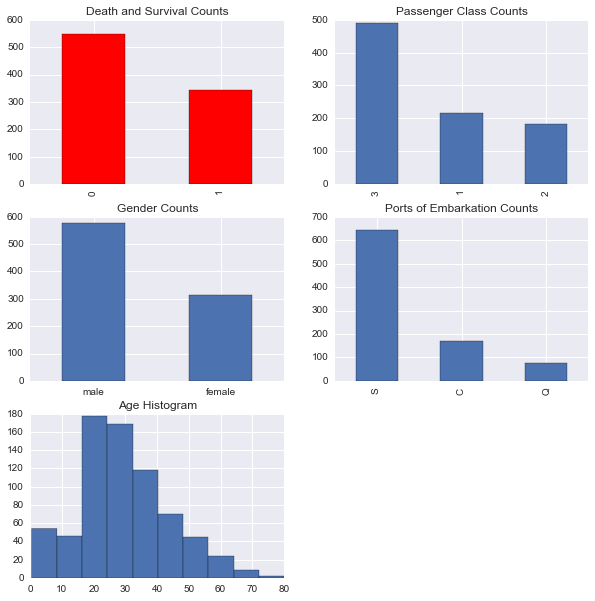

In [3]:
# Size of matplotlib figures that contain subplots
figsize_with_subplots = (10, 10)

# Set up a grid of plots
fig = plt.figure(figsize=figsize_with_subplots) 
fig_dims = (3, 2)

# Plot death and survival counts
plt.subplot2grid(fig_dims, (0, 0))
df_train['Survived'].value_counts().plot(kind='bar', 
                                         title='Death and Survival Counts',
                                         color='r',
                                         align='center')

# Plot Pclass counts
plt.subplot2grid(fig_dims, (0, 1))
df_train['Pclass'].value_counts().plot(kind='bar', 
                                       title='Passenger Class Counts')

# Plot Sex counts
plt.subplot2grid(fig_dims, (1, 0))
df_train['Sex'].value_counts().plot(kind='bar', 
                                    title='Gender Counts')
plt.xticks(rotation=0)

# Plot Embarked counts
plt.subplot2grid(fig_dims, (1, 1))
df_train['Embarked'].value_counts().plot(kind='bar', 
                                         title='Ports of Embarkation Counts')

# Plot the Age histogram
plt.subplot2grid(fig_dims, (2, 0))
df_train['Age'].hist()
plt.title('Age Histogram')

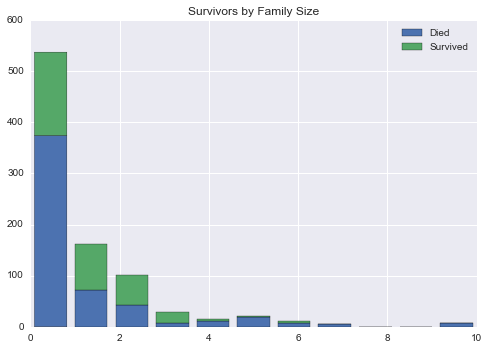

In [4]:
# Get the unique values of Embarked and its maximum
family_sizes = np.sort(df_train['FamilySize'].unique())
family_size_max = max(family_sizes)

df1 = df_train[df_train['Survived'] == 0]['FamilySize']
df2 = df_train[df_train['Survived'] == 1]['FamilySize']
plt.hist([df1, df2], 
         bins=family_size_max + 1, 
         range=(0, family_size_max), 
         stacked=True)
plt.legend(('Died', 'Survived'), loc='best')
plt.title('Survivors by Family Size')

## Normalized Plots

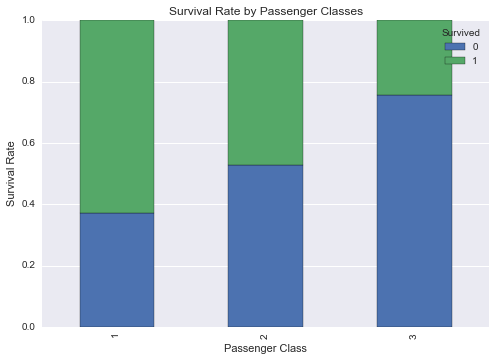

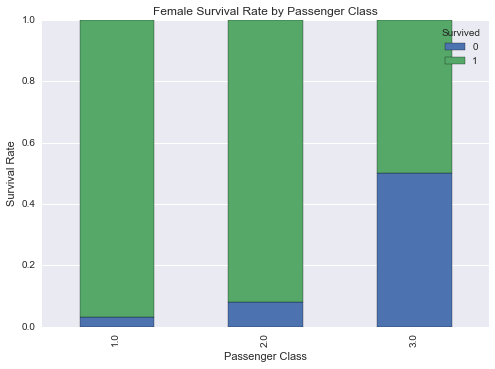

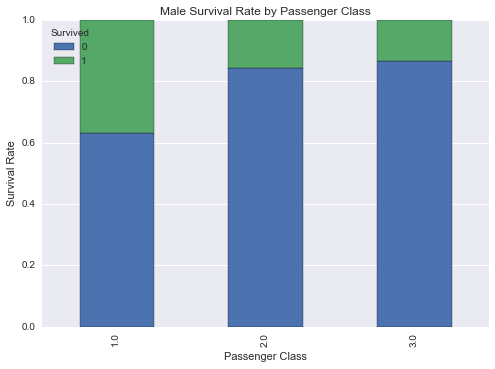

In [5]:
pclass_xt = pd.crosstab(df_train['Pclass'], df_train['Survived'])

# Normalize the cross tab to sum to 1:
pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

pclass_xt_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Survival Rate by Passenger Classes')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Plot survival rate by Sex
females_df = df_train[df_train['Sex'] == 'female']
females_xt = pd.crosstab(females_df['Pclass'], df_train['Survived'])
females_xt_pct = females_xt.div(females_xt.sum(1).astype(float), axis=0)
females_xt_pct.plot(kind='bar', 
                    stacked=True, 
                    title='Female Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Plot survival rate by Pclass
males_df = df_train[df_train['Sex'] == 'male']
males_xt = pd.crosstab(males_df['Pclass'], df_train['Survived'])
males_xt_pct = males_xt.div(males_xt.sum(1).astype(float), axis=0)
males_xt_pct.plot(kind='bar', 
                  stacked=True, 
                  title='Male Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

## Scatter Plots, subplots

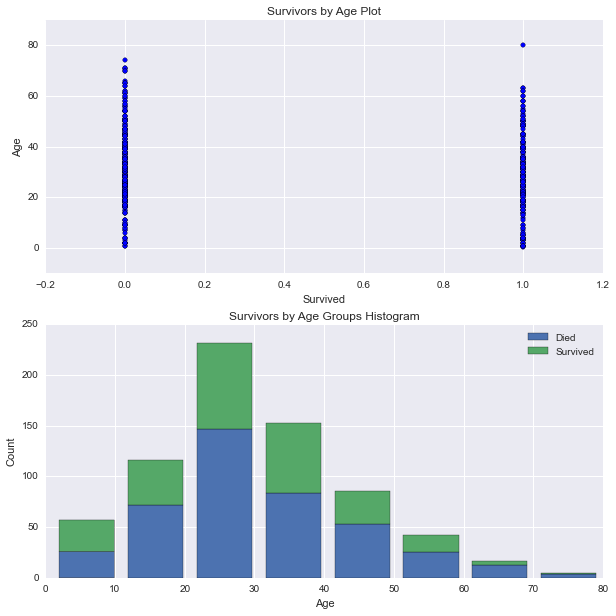

In [6]:
# Set up a grid of plots
fig, axes = plt.subplots(2, 1, figsize=figsize_with_subplots)

# Histogram of AgeFill segmented by Survived
df1 = df_train[df_train['Survived'] == 0]['Age']
df2 = df_train[df_train['Survived'] == 1]['Age']
max_age = max(df_train['AgeFill'])

axes[1].hist([df1, df2], 
             bins=max_age / 10, 
             range=(1, max_age), 
             stacked=True)
axes[1].legend(('Died', 'Survived'), loc='best')
axes[1].set_title('Survivors by Age Groups Histogram')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

# Scatter plot Survived and AgeFill
axes[0].scatter(df_train['Survived'], df_train['AgeFill'])
axes[0].set_title('Survivors by Age Plot')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Age')

## Kernel Density Estimation Plots

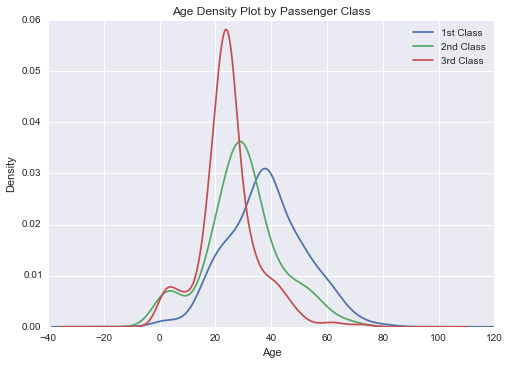

In [7]:
# Get the unique values of Pclass:
passenger_classes = np.sort(df_train['Pclass'].unique())

for pclass in passenger_classes:
    df_train.AgeFill[df_train.Pclass == pclass].plot(kind='kde')
plt.title('Age Density Plot by Passenger Class')
plt.xlabel('Age')
plt.legend(('1st Class', '2nd Class', '3rd Class'), loc='best')